<a href="https://colab.research.google.com/github/KshitijShinde/Skill/blob/main/Skill_LCA_FINAL_Blockwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA


In [2]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/dataset/train_test_network.csv")
target_column = 'label'

# Keep only numeric data and drop NaNs
df = df.select_dtypes(include=[np.number])
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Separate features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

# Encode target if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)


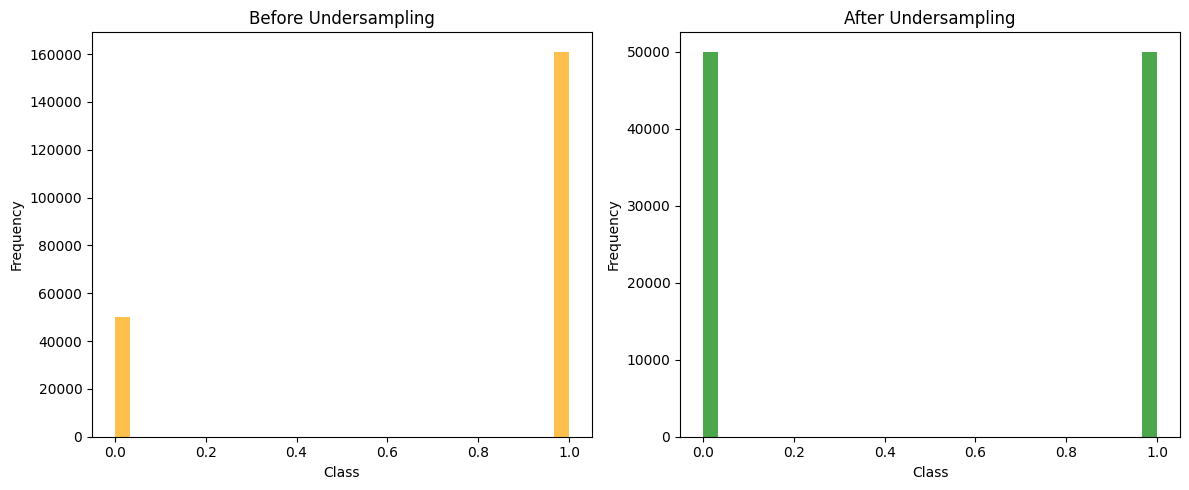

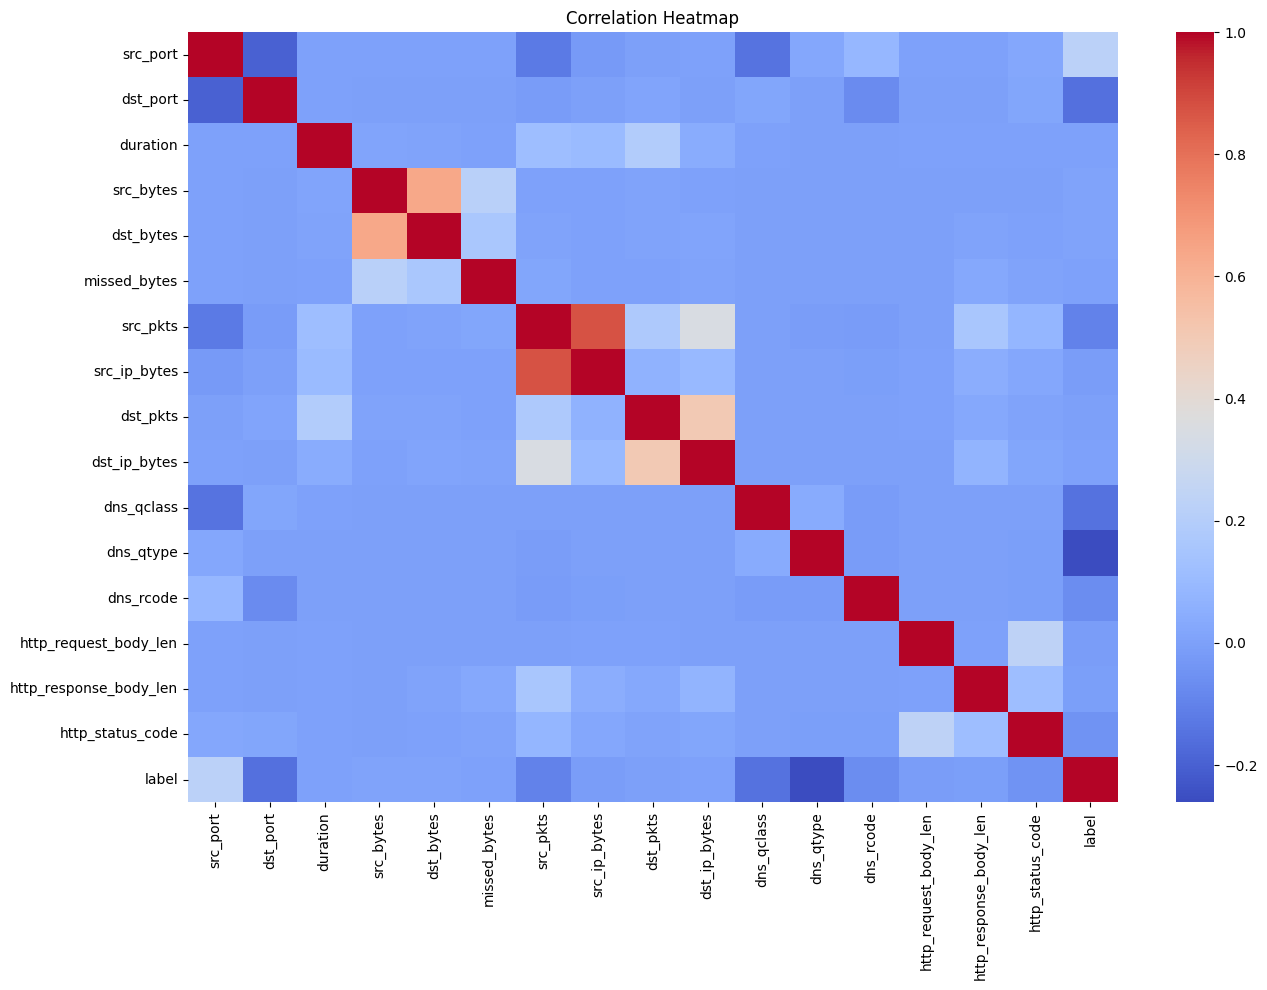

In [3]:
# Class distribution before and after undersampling
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y, bins=30, color='orange', alpha=0.7)
plt.title('Before Undersampling')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_resampled, bins=30, color='green', alpha=0.7)
plt.title('After Undersampling')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Correlation heatmap
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df[target_column] = y.values

plt.figure(figsize=(15, 10))
sns.heatmap(X_scaled_df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


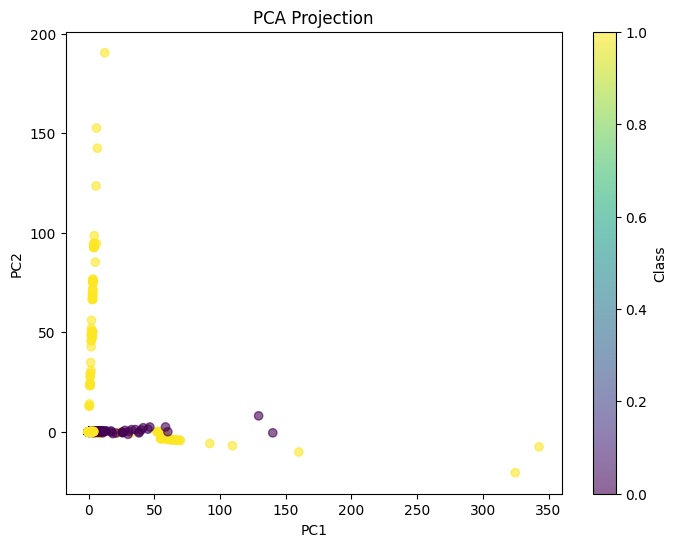

In [4]:
# PCA 2D Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title('PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Class')
plt.show()


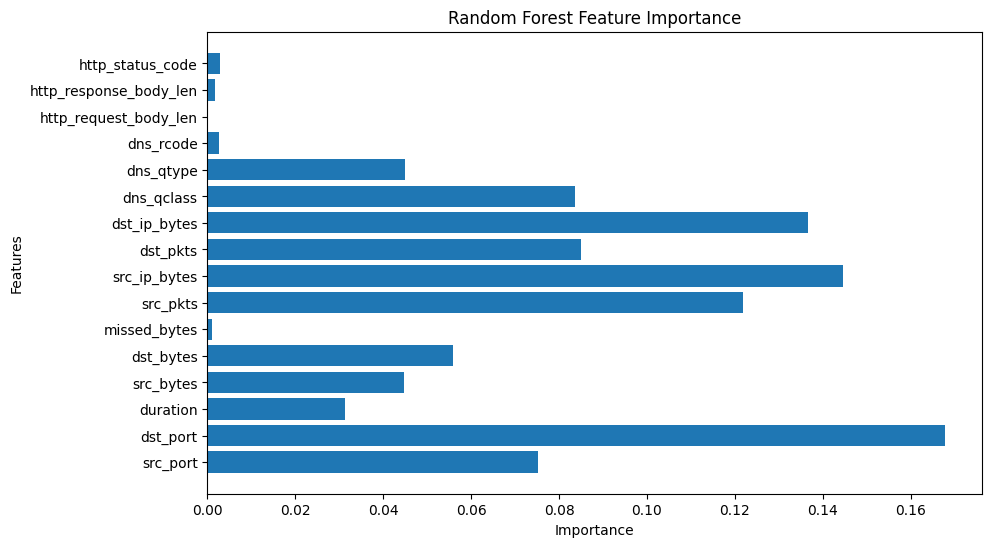

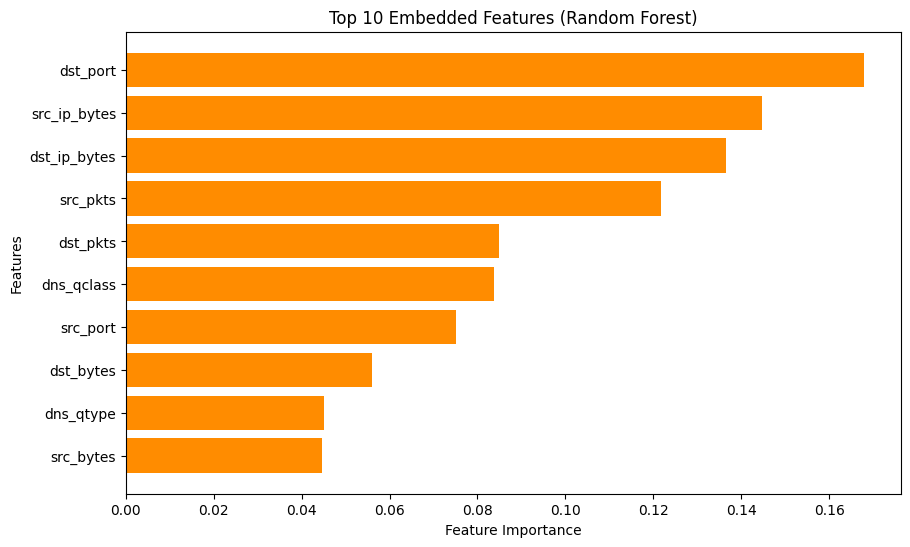

Embedded Feature Selection - Top 10 Features:
Index(['src_bytes', 'dns_qtype', 'dst_bytes', 'src_port', 'dns_qclass',
       'dst_pkts', 'src_pkts', 'dst_ip_bytes', 'src_ip_bytes', 'dst_port'],
      dtype='object')


In [5]:
# Train Random Forest and plot feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
feat_importance = rf_model.feature_importances_

# Plot all feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feat_importance)), feat_importance)
plt.yticks(range(len(feat_importance)), X.columns)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Top 10 embedded features
top_n = 10
top_indices = np.argsort(feat_importance)[-top_n:]
top_features_embedded = X.columns[top_indices]
top_importances = feat_importance[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features_embedded, top_importances, color='darkorange')
plt.title(f'Top {top_n} Embedded Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

print(f"Embedded Feature Selection - Top {top_n} Features:\n{top_features_embedded}")


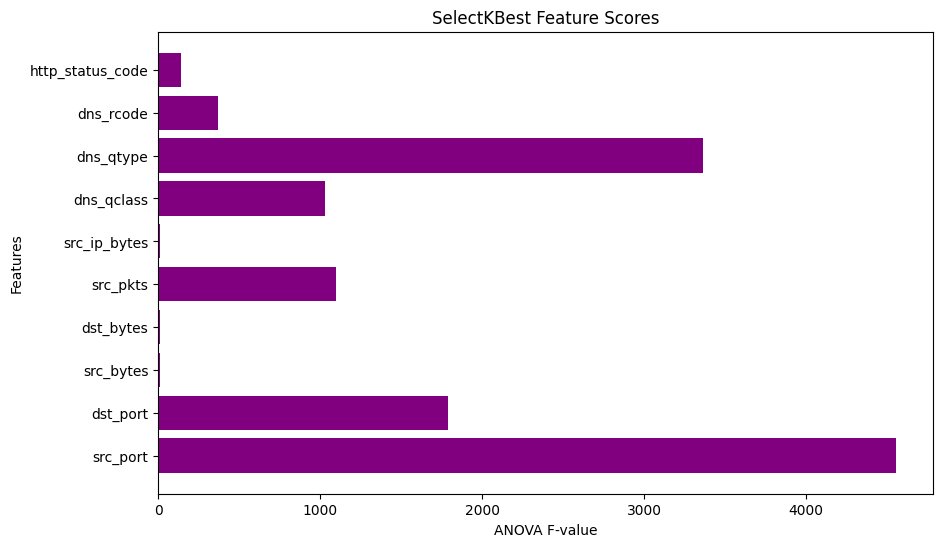

Filter Feature Selection - Top 10 Features:
Index(['src_port', 'dst_port', 'src_bytes', 'dst_bytes', 'src_pkts',
       'src_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode',
       'http_status_code'],
      dtype='object')


In [6]:
selector = SelectKBest(score_func=f_classif, k=10)
X_kbest = selector.fit_transform(X_train, y_train)
kbest_features = X.columns[selector.get_support()]
kbest_scores = selector.scores_[selector.get_support()]

plt.figure(figsize=(10, 6))
plt.barh(kbest_features, kbest_scores, color='purple')
plt.title("SelectKBest Feature Scores")
plt.xlabel("ANOVA F-value")
plt.ylabel("Features")
plt.show()

print(f"Filter Feature Selection - Top 10 Features:\n{kbest_features}")


In [7]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]

print(f"Wrapper Feature Selection - Top 10 Features using RFE:\n{selected_features_rfe}")


Wrapper Feature Selection - Top 10 Features using RFE:
Index(['src_port', 'dst_port', 'duration', 'dst_bytes', 'src_pkts',
       'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype'],
      dtype='object')



Bagging Model - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



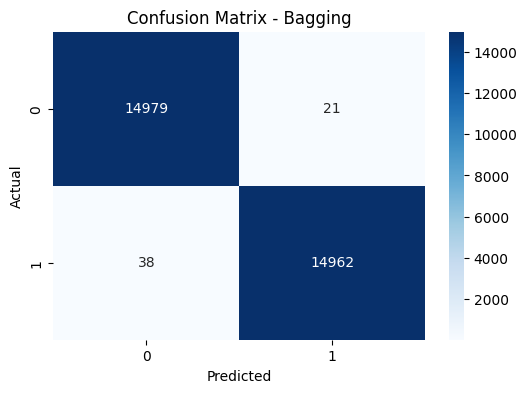


Boosting Model - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       0.99      1.00      0.99     15000

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



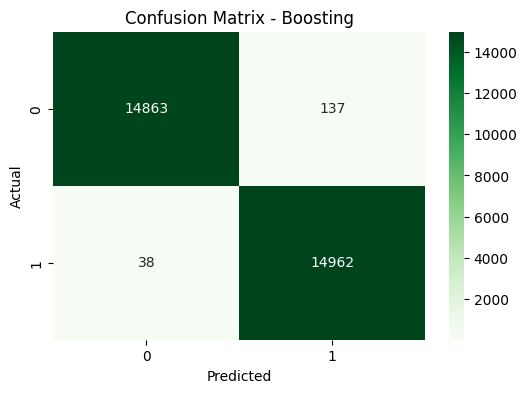

In [8]:
# Bagging Classifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

print("\nBagging Model - Classification Report:")
print(classification_report(y_test, y_pred_bagging))

cm_bag = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Bagging")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Boosting Classifier
boosting_model = GradientBoostingClassifier(random_state=42)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)

print("\nBoosting Model - Classification Report:")
print(classification_report(y_test, y_pred_boosting))

cm_boost = confusion_matrix(y_test, y_pred_boosting)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
